## Stock Price Prediction

In [20]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Importing dataset

data = pd.read_csv("../input/nyse/prices-split-adjusted.csv")
df = pd.DataFrame(data)

In [22]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### Data Information

In [23]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [24]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)


date 	-	 0.0
symbol 	-	 0.0
open 	-	 0.0
close 	-	 0.0
low 	-	 0.0
high 	-	 0.0
volume 	-	 0.0


> Since there is no null valus, we can move further 

<AxesSubplot:>

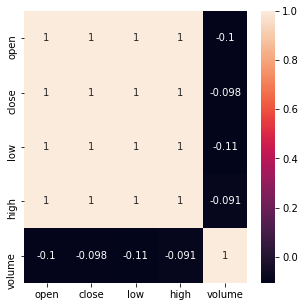

In [25]:
df = df[df['symbol']=='AAP']   # Choosin stock values for any company 

cormap = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

In [26]:
def get_corelated_col(cor_dat, threshold): 
  # Cor_data to be column along which corelation to be measured 
  #Threshold be the value above which of corelation to considered
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df


In [27]:
top_corelated_values = get_corelated_col(cormap['close'], 0.60)
top_corelated_values

,corr value
open,0.999382
close,1.000000
low,0.999615
high,0.999737


> Looks like all colums except _volume_ are ***highly co-related***. Using them for predictions.

In [28]:
df = df[top_corelated_values.index]
df.head()

,open,close,low,high
253,40.700001,40.380001,40.360001,41.040001
720,40.299999,40.139999,39.720001,40.310001
1188,40.049999,40.490002,40.049999,40.779999
1656,39.549999,40.480000,39.549999,40.540001
2124,40.250000,40.639999,40.110001,40.820000


In [29]:
df.shape

(1762, 4)

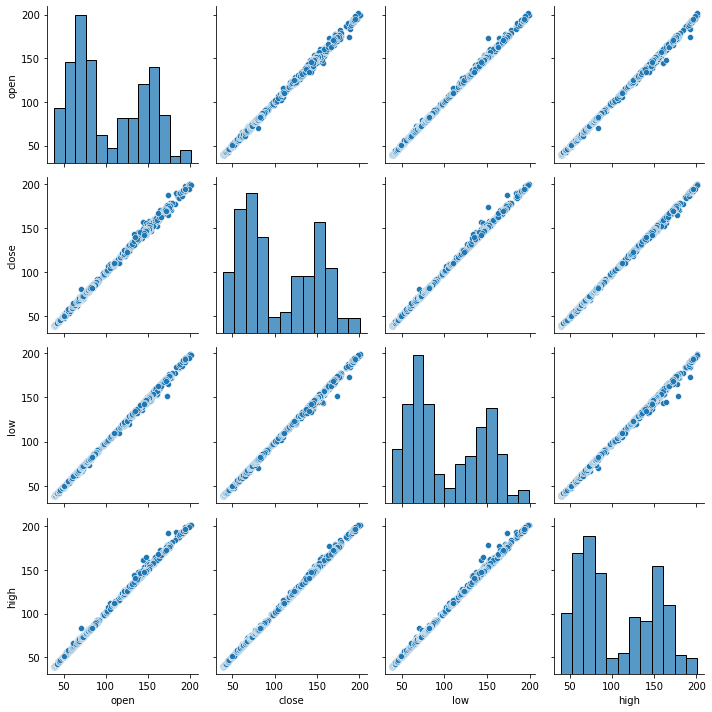

In [30]:
sns.pairplot(df)
plt.tight_layout()

> Since other parameters have linear relationship with __close__, we are using some linear models fore prediction

In [31]:
X = df.drop(['close'], axis=1)
y = df['close']

> Since range of data in different columns veries significantly we need to scale the independent variable i.e. X. For this we will use Min-Max Scaling.

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,open,low,high
0,0.012001,0.012392,0.010256
1,0.009539,0.008387,0.005746
2,0.008000,0.010452,0.008649
3,0.004923,0.007323,0.007167
4,0.009231,0.010827,0.008897


## Prediction Model

In [33]:
#now lets split data in test train pairs

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

### 1. Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

# model training

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression()

In [35]:
# prediction
y_pred_1 = model_1.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1})
pred_df.head()

,Actual,Predicted
675111,173.660004,173.682489
675608,171.919998,172.593759
676105,172.000000,171.182789
676602,187.789993,187.980305
677099,187.029999,188.440838


In [36]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.9931342019332019


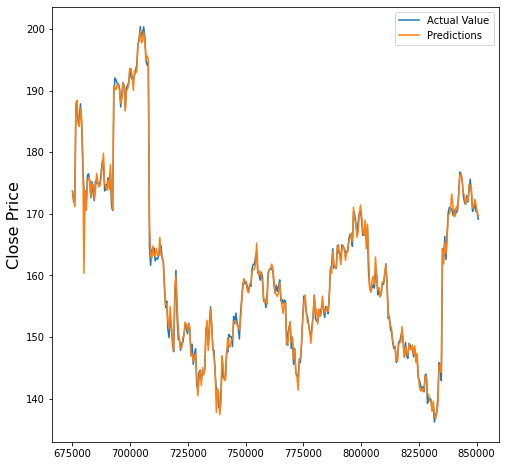

In [37]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 2. ANN

In [38]:
# Model Creation

from keras.models import Sequential
from keras.layers import Dense

def regressor(inp_dim):
    
    model = Sequential()
    
    model.add(Dense(20, input_dim=inp_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [39]:
# Model Training

model_2 = regressor(inp_dim=3)
model_2.fit(X_train, y_train, epochs=70, validation_split=0.2)

Epoch 1/70
36/36 [==============================] - 1s 12ms/step - loss: 6039.9136 - val_loss: 22082.7910
Epoch 2/70
36/36 [==============================] - 0s 3ms/step - loss: 6148.0490 - val_loss: 21983.5176
Epoch 3/70
36/36 [==============================] - 0s 4ms/step - loss: 6048.6005 - val_loss: 21526.3438
Epoch 4/70
36/36 [==============================] - 0s 4ms/step - loss: 5898.5889 - val_loss: 20082.7168
Epoch 5/70
36/36 [==============================] - 0s 4ms/step - loss: 5210.5215 - val_loss: 16763.3730
Epoch 6/70
36/36 [==============================] - 0s 4ms/step - loss: 4012.6616 - val_loss: 11200.8164
Epoch 7/70
36/36 [==============================] - 0s 4ms/step - loss: 2315.5936 - val_loss: 4884.3481
Epoch 8/70
36/36 [==============================] - 0s 4ms/step - loss: 729.7410 - val_loss: 1114.4911
Epoch 9/70
36/36 [==============================] - 0s 4ms/step - loss: 82.9398 - val_loss: 254.4487
Epoch 10/70
36/36 [==============================] - 0s 4ms/s

In [40]:
# Prediction

y_pred_2 = model_2.predict(X_test)

In [41]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2.flatten()})
pred_df.head()

,Actual,Predicted
675111,173.660004,174.118927
675608,171.919998,172.438049
676105,172.000000,170.655121
676602,187.789993,179.478363
677099,187.029999,188.179977


In [42]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.9877609818668082


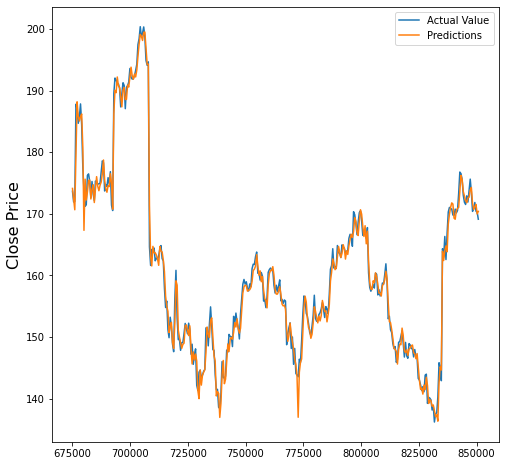

In [43]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 3. CNN

In [44]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [45]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

def reg():
    
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=(3,), padding='same', activation='relu', input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=(5,), padding='same', activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(units = 1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [46]:
# Model Training

model_3 = reg()
model_3.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
36/36 [==============================] - 1s 11ms/step - loss: 5823.3276 - val_loss: 11471.7568
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 1123.1389 - val_loss: 171.6087
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 15.3328 - val_loss: 8.5728
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 2.9474 - val_loss: 8.8803
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 1.0818 - val_loss: 4.4193
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6523 - val_loss: 1.8011
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.4726 - val_loss: 1.4435
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.4215 - val_loss: 1.4433
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 0.4324 - val_loss: 1.4659
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 0.3767 - val_loss: 1.

In [47]:
# Prediction

y_pred_3 = model_3.predict(X_test)

In [48]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

,Actual,Predicted
675111,173.660004,174.413849
675608,171.919998,172.824112
676105,172.000000,171.037766
676602,187.789993,182.193436
677099,187.029999,188.761780


In [49]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.9905183812120758


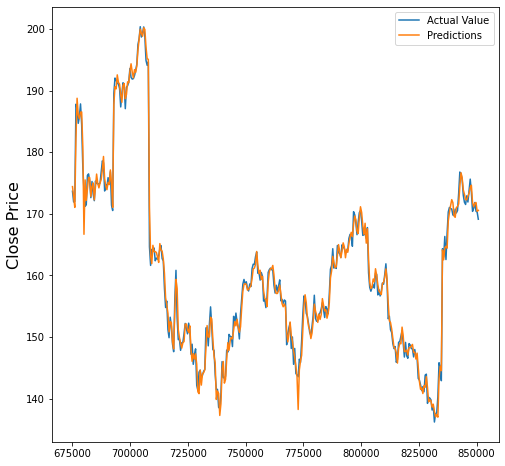

In [50]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

> Comparision of Accuracies of different models

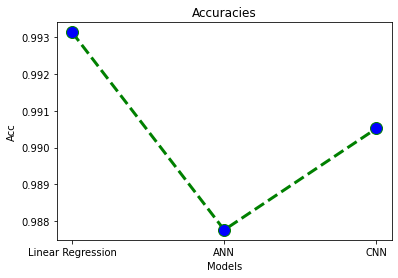

In [51]:
plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['Linear Regression', 'ANN', 'CNN'])
plt.show()

**********************

### Now converting data in a time series data and applying some more models.

In [52]:
close = df.reset_index()['close']
close.head()

0    40.380001
1    40.139999
2    40.490002
3    40.480000
4    40.639999
Name: close, dtype: float64

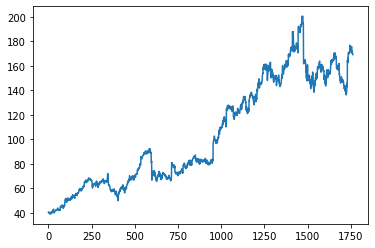

In [53]:
plt.plot(close)
plt.show()

In [54]:
time_step = 30
X, y = [], []

for i in range(len(close)-time_step-1):
    X.append(close[i:(i+time_step)])
    y.append(close[(i+time_step)])

X = np.array(X)
y = np.array(y)

In [55]:
X[:5]

array([[40.380001, 40.139999, 40.490002, 40.48    , 40.639999, 40.240002,
        39.540001, 40.09    , 39.560001, 39.310001, 39.5     , 39.16    ,
        39.23    , 39.740002, 40.5     , 40.549999, 40.59    , 39.77    ,
        39.450001, 40.490002, 41.189999, 41.189999, 40.93    , 40.720001,
        40.810001, 41.57    , 42.330002, 42.549999, 42.810001, 42.630001],
       [40.139999, 40.490002, 40.48    , 40.639999, 40.240002, 39.540001,
        40.09    , 39.560001, 39.310001, 39.5     , 39.16    , 39.23    ,
        39.740002, 40.5     , 40.549999, 40.59    , 39.77    , 39.450001,
        40.490002, 41.189999, 41.189999, 40.93    , 40.720001, 40.810001,
        41.57    , 42.330002, 42.549999, 42.810001, 42.630001, 42.880001],
       [40.490002, 40.48    , 40.639999, 40.240002, 39.540001, 40.09    ,
        39.560001, 39.310001, 39.5     , 39.16    , 39.23    , 39.740002,
        40.5     , 40.549999, 40.59    , 39.77    , 39.450001, 40.490002,
        41.189999, 41.189999, 40.93 

In [56]:
y[:5]

array([42.880001, 40.150002, 40.      , 40.240002, 40.220001])

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.007567,0.006079,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,...,0.007420,0.007420,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399
1,0.006079,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,...,0.007420,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957
2,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,...,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935
3,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,0.000434,...,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935,0.000000
4,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,0.000434,0.003598,...,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935,0.000000,0.001496


## Prediction

In [58]:
#now lets split data in test train pairs

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

### 1. LSTM

In [59]:
X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_ = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [60]:
from tensorflow.keras.layers import LSTM

def Reg():
    model = Sequential()
    
    model.add(LSTM(70, return_sequences=True, input_shape=(30,1)))
    model.add(LSTM(70, return_sequences=True))
    model.add(LSTM(70))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [61]:
# Model Training

model_1 = reg()
model_1.fit(X_train_, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 1s 20ms/step - loss: 5263.1816 - val_loss: 374.2244
Epoch 2/100
35/35 [==============================] - 0s 13ms/step - loss: 143.8724 - val_loss: 69.1650
Epoch 3/100
35/35 [==============================] - 0s 13ms/step - loss: 18.9093 - val_loss: 32.3330
Epoch 4/100
35/35 [==============================] - 0s 12ms/step - loss: 17.6992 - val_loss: 36.9906
Epoch 5/100
35/35 [==============================] - 0s 13ms/step - loss: 15.3594 - val_loss: 46.4716
Epoch 6/100
35/35 [==============================] - 0s 14ms/step - loss: 18.0349 - val_loss: 43.0336
Epoch 7/100
35/35 [==============================] - 0s 14ms/step - loss: 17.1972 - val_loss: 44.4252
Epoch 8/100
35/35 [==============================] - 0s 14ms/step - loss: 15.8552 - val_loss: 35.6157
Epoch 9/100
35/35 [==============================] - 0s 14ms/step - loss: 16.4335 - val_loss: 32.1757
Epoch 10/100
35/35 [==============================] - 0s 13ms/step - loss: 16.

In [62]:
# Prediction

y_pred_1 = model_1.predict(X_test_)

In [63]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1.flatten()})
pred_df.head()

,Actual,Predicted
0,184.690002,187.363693
1,185.770004,188.112045
2,187.839996,188.959335
3,184.449997,190.631851
4,177.539993,190.848419


In [64]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.8540723542553025


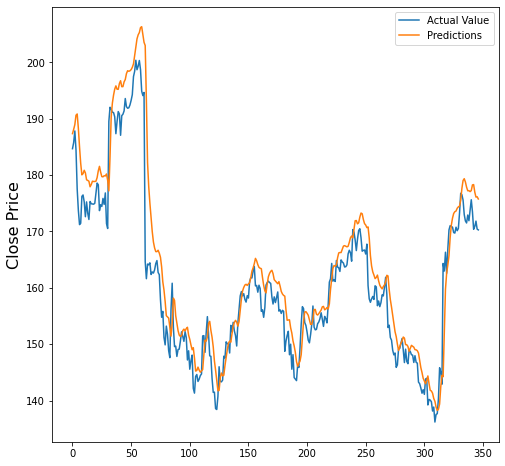

In [65]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 2. ANN

In [66]:
# Model Training

model_2 = regressor(inp_dim=30)
model_2.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 1s 10ms/step - loss: 6247.7302 - val_loss: 22389.2695
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 6476.4340 - val_loss: 21955.1543
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 6220.2017 - val_loss: 19594.3984
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 5375.9773 - val_loss: 12539.9854
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 3518.0683 - val_loss: 2452.4004
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 1050.2850 - val_loss: 773.7950
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 232.8285 - val_loss: 1657.7784
Epoch 8/100
35/35 [==============================] - 0s 4ms/step - loss: 208.3441 - val_loss: 1392.7090
Epoch 9/100
35/35 [==============================] - 0s 4ms/step - loss: 207.8356 - val_loss: 1325.0494
Epoch 10/100
35/35 [==============================] - 

In [67]:
# Prediction

y_pred_2 = model_2.predict(X_test)

In [68]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.7776921663567443


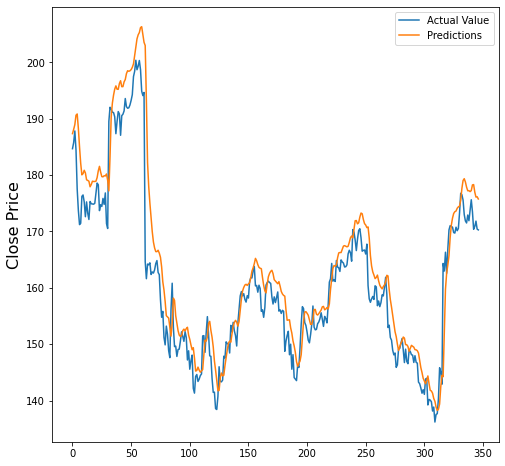

In [69]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 3. CNN

In [70]:
# Model Training

model_3 = reg()
model_3.fit(X_train_, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 1s 18ms/step - loss: 4799.0079 - val_loss: 431.4546
Epoch 2/100
35/35 [==============================] - 0s 13ms/step - loss: 152.9122 - val_loss: 108.9082
Epoch 3/100
35/35 [==============================] - 0s 13ms/step - loss: 16.2593 - val_loss: 36.0084
Epoch 4/100
35/35 [==============================] - 0s 14ms/step - loss: 15.8262 - val_loss: 41.0867
Epoch 5/100
35/35 [==============================] - 0s 13ms/step - loss: 14.8779 - val_loss: 46.3527
Epoch 6/100
35/35 [==============================] - 0s 13ms/step - loss: 16.6008 - val_loss: 33.8264
Epoch 7/100
35/35 [==============================] - 0s 13ms/step - loss: 16.1398 - val_loss: 32.5189
Epoch 8/100
35/35 [==============================] - 0s 13ms/step - loss: 13.0114 - val_loss: 37.8520
Epoch 9/100
35/35 [==============================] - 0s 13ms/step - loss: 15.3161 - val_loss: 31.2398
Epoch 10/100
35/35 [==============================] - 0s 13ms/step - loss: 13

In [71]:
# Prediction

y_pred_3 = model_3.predict(X_test_)

In [72]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

,Actual,Predicted
0,184.690002,187.443634
1,185.770004,187.687561
2,187.839996,189.151138
3,184.449997,190.904144
4,177.539993,189.504868


In [73]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.8647900448552586


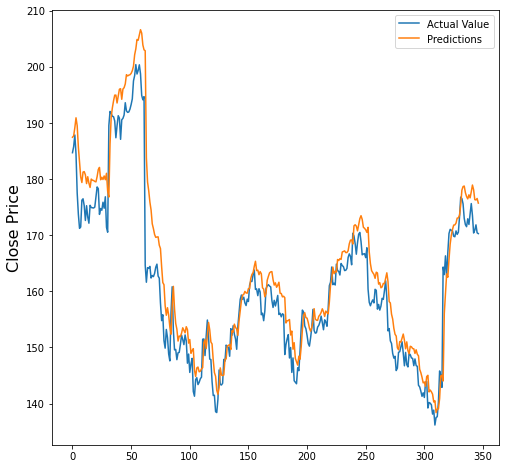

In [74]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

> Comparision of Accuracies of different models

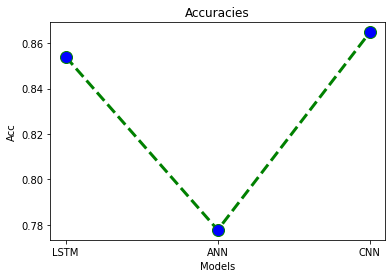

In [75]:

plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['LSTM', 'ANN', 'CNN'])
plt.show()